# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

### Imports and Weights and Biases login
Main imports to run the code. Installation, login and eventually update of wandb.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

#Tracking experiments
import wandb
wandb.login()

wandb: Currently logged in as: niccolo-arati (dla-labs). Use `wandb login --relogin` to force relogin


True

### Policy Network
A simple policy network with one hidden layer. A temperature parameter could be specified to smooth the output (default value is 1, which leads to no changes).

In [10]:
def temperature_scaled_softmax(logits, temperature):
    logits = logits / temperature
    return F.softmax(logits, dim=-1)

# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env, inner_size = 128, T=1.0):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, env.action_space.n)
        self.relu = nn.ReLU()
        self.temperature = T

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = temperature_scaled_softmax(self.fc2(s), self.temperature)
        return s

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here.

### Reinforce
I decided to define a wrapper class for executing the REINFORCE policy gradient algorithm. This class will also be used as root for a class inheritance hierarchy, extending this class to add the new functionalities required by the notebook.

As attributes, it requires a policy network, the environment to train the policy network, eventually an environment with rendering to show intermediate results, and some training hyperparameters:

1. gamma: used to compute discounted total reward, balances the importance of immediate versus future reward. A higher value gives a higher weight to future rewards while a lower value prioritizes immediate rewards.
2. num_episodes: number of episodes to train the policy network
3. lr: learning rate
4. max_len: maximum length of a single episode

The methods of the class are used to select actions (select_action and select_max_action) and run an episode in the environment (run_episode), as well as to execute the REINFORCE algorithm (reinforce).

In [3]:
class Reinforce:
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len = 500):
        self.policy = policy
        self.environment = env
        self.env_render = env_render
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.learning_rate = lr
        self.max_len = max_len #max length for each episode

    # Given an environment, observation, and policy, sample from pi(a | obs). Returns the
    # selected action and the log probability of that action (needed for policy gradient).
    def select_action(self, obs):
        dist = Categorical(self.policy(obs))
        action = dist.sample() 
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1))

    # Used for testing, select the most probabile action given the policy and the current observation.
    def select_max_action(self, obs):
        probs = self.policy(obs)
        action = torch.argmax(probs)
        log_prob = torch.log(torch.max(probs))
        return(action.item(), log_prob.reshape(1))

    # Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
    # .copy() the final numpy array.
    def compute_returns(self, rewards):
        return np.flip(np.cumsum([self.gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

    # sets an environment with rendering to display final results
    def setEnvRender(self, env_render):
        self.env_render = env_render

    # Given an environment and a policy, run it up to the maximum number of steps.
    # If test is True, then the action is selected with the deterministic way
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action, log_prob) = self.select_max_action(obs)
            else:
                (action, log_prob) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        return (observations, actions, torch.cat(log_probs), rewards)

    # Implementation of the REINFORCE policy gradient algorithm. It does not require any argument, because the
    # parameters needed to run the algorithm are wrapped within the class as attributes.
    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Track episode rewards in a list.
        running_rewards = [0.0]

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Standardize returns.
            returns = (returns - returns.mean()) / returns.std()

            # Make an optimization step
            opt.zero_grad()
            loss = (-log_probs * returns).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics}) 

            # Render an episode after every 100 policy updates.
            if not episode % self.N:
                self.policy.eval()
                (obs, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards)

### Runs of REINFORCE
Once an object of the Reinforce class is instantiated, running the reinforce method trains the policy network. For subsequent testing, 20 episodes are executed by selecting actions with the highest probability, according to the last policy network trained. The average reward for each episode is observed.

The hyperparameters have been choosen empirically, I will not report runs that I used to decide their values. Since training the policy is stochastic, for each setting I performed the policy training 5 times, and then in the reports I reported the metrics of interest in a graphic with mean curve and standard variance.

These guidelines remain valid for the subsequent runs with the updated versions of REINFORCE.

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Running reward: 0.6497082233428956
Running reward: 23.190019938114148
Running reward: 34.2965949373752
Running reward: 82.70511604452692
Running reward: 93.05599589222612
Running reward: 97.93792739779911
Running reward: 97.94823068770908
Running reward: 97.4321737049628
Running reward: 97.27579236350714
Running reward: 98.13662530975331
Running reward: 98.19534296458968
Running reward: 98.33517156102218
Running reward: 98.26824690796535
Running reward: 95.66775462775256
Running reward: 97.85358418639588
Running reward: 93.03835264075786
Running reward: 98.25870593512299
Running reward: 98.34898775205852
Running reward: 98.34952226819374
Running reward: 96.9865712025036


Policy Loss,▄▃▂▃▄▂▃▂▆▄▅▃▂▄▅▃▄▅▅▁█▄▃▁▅▄▄▃▂▄▃▃▅▄▆▂▄▄▄▁
Running Reward,▁▂▂▂▃▅▇█████████████████████████████████
Policy Loss,-0.00899
Running Reward,98.34103


Running reward: 0.42808961868286133
Running reward: 25.863219355172127
Running reward: 48.50486924684883
Running reward: 82.82855868124207
Running reward: 94.0840698403936
Running reward: 96.56840462011412
Running reward: 98.00008763034171
Running reward: 77.04336354226602
Running reward: 96.82797656644448
Running reward: 97.15818445644356
Running reward: 98.02453171861248
Running reward: 98.34760131676703
Running reward: 98.08222405243808
Running reward: 98.31886604104206
Running reward: 98.3493439317235
Running reward: 98.34952437696586
Running reward: 98.1931484449106
Running reward: 98.34717201039915
Running reward: 98.2168495838246
Running reward: 96.20843634915487


Policy Loss,▅▃▁▂▆▅▃▅▅▄▅▄▆▄▄▆▄▅▅▅▆▄▇▄▄█▅▄▄▄▅▄▅▅▄▄▅▄▇▇
Running Reward,▁▂▂▃▄▆▇██▇███▇▇█████████████████████████
Policy Loss,-0.01536
Running Reward,97.1594


Running reward: 1.0608932495117187
Running reward: 21.76099091345924
Running reward: 57.34512706294905
Running reward: 91.65530371034195
Running reward: 95.37254665452285
Running reward: 90.49952093055856
Running reward: 97.88843788111278
Running reward: 98.32094715222074
Running reward: 96.65827759649117
Running reward: 98.12478714637611
Running reward: 98.34819488195659
Running reward: 97.59485343813407
Running reward: 91.70991170071443
Running reward: 82.90690033189746
Running reward: 73.33164629858186
Running reward: 78.9565067622796
Running reward: 71.85287770872525
Running reward: 86.06232391771704
Running reward: 97.87107920308149
Running reward: 97.88316670816815


Policy Loss,▂▁▄▅▂▁▁▁▂▂▅▃▃▂▃▃▃▃▂▃▃▃▄▃▃▂▂▃▂▃▅▅█▂▄▃▃▃▂▃
Running Reward,▁▂▂▄▅▇███▇██████████████▇▇▇▆▆▇▆▆▆▇██████
Policy Loss,-0.00332
Running Reward,97.88481


Running reward: 0.7774312019348145
Running reward: 21.03520649842848
Running reward: 46.62653593972456
Running reward: 92.65362679618268
Running reward: 96.47210269742361
Running reward: 95.46401282522424
Running reward: 98.15981128381767
Running reward: 97.41286383968063
Running reward: 98.32258456860892
Running reward: 98.06122814343607
Running reward: 98.17195798977701
Running reward: 98.22462588853817
Running reward: 98.19977529855937
Running reward: 98.34863885150278
Running reward: 98.34952020251781
Running reward: 98.3264891936881
Running reward: 98.25080875853736
Running reward: 97.74985769077867
Running reward: 98.34434074889974
Running reward: 96.50468099790825


Policy Loss,▃█▁▃▄▂▃▂▃▂▃▂▃▃▆▂▃▃▄▃▅▂▅▃▄▂▃▃▄▂▃▂▃▃▃▂▃▁▄▂
Running Reward,▁▂▂▃▄▆██████████████████████████████████
Policy Loss,0.00449
Running Reward,98.30753


Running reward: 0.7774312019348145
Running reward: 28.666278900224185
Running reward: 68.36353509333874
Running reward: 95.22789090103967
Running reward: 95.40643687839002
Running reward: 97.07285936001247
Running reward: 96.68920068707166
Running reward: 98.30876741683528
Running reward: 98.31645413151655
Running reward: 98.00210736414499
Running reward: 98.34746855272117
Running reward: 97.74791352321091
Running reward: 98.07643203330349
Running reward: 98.31865023424464
Running reward: 98.3493426540331
Running reward: 98.25732959429939
Running reward: 96.06293294061365
Running reward: 98.0593281013731
Running reward: 98.10253615536354
Running reward: 96.66928990583492


Policy Loss,▆▄▁▅▃▃▆▇▅▆▇▆▄▅▅▇▆▆▇▇▆▇▆▅▆▅▄▃▄▇▅▅▇▇█▆█▆▆▄
Running Reward,▁▂▃▄▆███████████████████████████████████
Policy Loss,-0.00856
Running Reward,98.33905


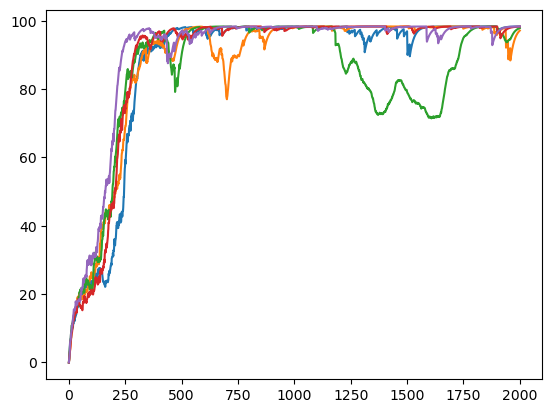

In [8]:
# Your code here. You should be able to train an agent to solve Cartpole. This will be our starting point.

n_run = 5
seeds = [11, 111, 1111, 11111, 111111]
val_seeds = [22, 222, 22222, 22222, 222222]

for i in range(n_run):

    #Instantiate a rendering and a non rendering environment
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    #track run
    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Final",
          # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
          name=f"Reinforce",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "temperature": 20})

    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"])

    # Train the agent.
    r = Reinforce(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"])
    (rewards) = r.reinforce()
    plt.plot(rewards)

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [9]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards) = r.run_episode(display=True, test=True) #deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

Average reward for episode: 500.0


### wandb Reinforce Report
Add Comments

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

### ReinforceAvg
The class extends Reinforce and implements the requirements mentioned above.
Two attributes have been added: N and eval_episodes.
The methods run_episode and reinforce have been overridden to implement the new required functionalities.

In [4]:
class ReinforceAvg(Reinforce):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, max_len)
        self.N = N
        self.M = eval_episodes

    # Override to collect also episode length
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action,log_prob) = self.select_max_action(obs)
            else:
                (action, log_prob) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        length = i + 1
        return (observations, actions, torch.cat(log_probs), rewards, length)

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Track episode rewards, average rewards and average episode lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Standardize returns.
            returns = (returns - returns.mean()) / returns.std()

            # Make an optimization step
            opt.zero_grad()
            loss = (-log_probs * returns).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics})

            # Render M episodes after every N policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length) = self.run_episode()
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards, average_rewards, average_lengths)

### Runs of ReinforceAvg

Average Total: 26.1
Average Length: 26.1
Running reward: 0.6497082233428956
Average Total: 24.6
Average Length: 24.6
Running reward: 21.639039001083443
Average Total: 47.9
Average Length: 47.9
Running reward: 40.54673963756401
Average Total: 287.1
Average Length: 287.1
Running reward: 84.57872931482663
Average Total: 500.0
Average Length: 500.0
Running reward: 96.77794912729506
Average Total: 500.0
Average Length: 500.0
Running reward: 98.19887288148479
Average Total: 473.5
Average Length: 473.5
Running reward: 96.39959853196005
Average Total: 500.0
Average Length: 500.0
Running reward: 98.1621801382657
Average Total: 500.0
Average Length: 500.0
Running reward: 96.16301391602961
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33658014622266
Average Total: 419.4
Average Length: 419.4
Running reward: 97.37322463544656
Average Total: 500.0
Average Length: 500.0
Running reward: 97.51135619416021
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33288863760637
Aver

Average Length,▁▁▁▅██████▇██████▇██
Average Total Reward,▁▁▁▅██████▇██████▇██
Policy Loss,▅▅▆▅█▅▅▅▄▅▅▄▄▅▅▆▅▄▆▄▃▅▅▅▄▄▄▅▃▄▆▅▄▁▂▇▄▄▅▅
Running Reward,▁▂▂▃▃▆▇▇████████████████████████████████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,0.02174
Running Reward,98.30967


Average Total: 22.0
Average Length: 22.0
Running reward: 0.42808961868286133
Average Total: 24.4
Average Length: 24.4
Running reward: 19.625021888217955
Average Total: 98.5
Average Length: 98.5
Running reward: 48.295678558866854
Average Total: 161.5
Average Length: 161.5
Running reward: 82.49857306583337
Average Total: 297.0
Average Length: 297.0
Running reward: 94.4010263009518
Average Total: 500.0
Average Length: 500.0
Running reward: 97.86729762778286
Average Total: 500.0
Average Length: 500.0
Running reward: 97.48982015070682
Average Total: 500.0
Average Length: 500.0
Running reward: 98.34169880695528
Average Total: 489.1
Average Length: 489.1
Running reward: 98.32634760457584
Average Total: 500.0
Average Length: 500.0
Running reward: 98.326731144662
Average Total: 500.0
Average Length: 500.0
Running reward: 98.34939049729928
Average Total: 500.0
Average Length: 500.0
Running reward: 98.00538232565965
Average Total: 500.0
Average Length: 500.0
Running reward: 98.34719474567157
Aver

Average Length,▁▁▂▃▅███████████▄███
Average Total Reward,▁▁▂▃▅███████████▄███
Policy Loss,▆▆▃▁█▇▄█▆▆▇▆▅▅▇▇▅▅▇▆▆▆▇▅▆▅▇▅▆▆▃▅▄▇▆▆▅▅▆▆
Running Reward,▁▂▂▂▄▇▇███████████████████████▆▆▇███████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,0.00594
Running Reward,94.65579


Average Total: 25.3
Average Length: 25.3
Running reward: 1.0608932495117187
Average Total: 50.2
Average Length: 50.2
Running reward: 32.59780812235765
Average Total: 127.0
Average Length: 127.0
Running reward: 58.95409931165832
Average Total: 344.2
Average Length: 344.2
Running reward: 85.02111269036614
Average Total: 424.8
Average Length: 424.8
Running reward: 96.0252139522151
Average Total: 451.1
Average Length: 451.1
Running reward: 95.1179328861359
Average Total: 499.3
Average Length: 499.3
Running reward: 92.96981737566722
Average Total: 464.1
Average Length: 464.1
Running reward: 94.33237852529099
Average Total: 500.0
Average Length: 500.0
Running reward: 97.03891592991842
Average Total: 500.0
Average Length: 500.0
Running reward: 98.26236176900765
Average Total: 500.0
Average Length: 500.0
Running reward: 96.66115217325843
Average Total: 500.0
Average Length: 500.0
Running reward: 97.90964101600441
Average Total: 500.0
Average Length: 500.0
Running reward: 97.97993547350484
Aver

Average Length,▁▁▂▆▇▇█▇██████████▇█
Average Total Reward,▁▁▂▆▇▇█▇██████████▇█
Policy Loss,▄▂▃▁█▄▄▅▃▃▄▄▅▅▄▅▅▄▄▅▆▄▄▅▆▄▇▄▅▅▂▁▄▂▅▆▃▃▄▄
Running Reward,▁▂▃▃▅▇▇█████████████████████████████████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,-0.0102
Running Reward,98.34773


Average Total: 21.2
Average Length: 21.2
Running reward: 0.7774312019348145
Average Total: 31.8
Average Length: 31.8
Running reward: 26.155333854751614
Average Total: 121.4
Average Length: 121.4
Running reward: 57.638186255164385
Average Total: 409.5
Average Length: 409.5
Running reward: 91.42193752211968
Average Total: 456.2
Average Length: 456.2
Running reward: 93.15344428614723
Average Total: 500.0
Average Length: 500.0
Running reward: 95.2997486638782
Average Total: 494.2
Average Length: 494.2
Running reward: 98.12568237592914
Average Total: 500.0
Average Length: 500.0
Running reward: 90.72505899983005
Average Total: 454.1
Average Length: 454.1
Running reward: 97.96031425800886
Average Total: 500.0
Average Length: 500.0
Running reward: 98.3357749806253
Average Total: 500.0
Average Length: 500.0
Running reward: 97.98431504315748
Average Total: 500.0
Average Length: 500.0
Running reward: 96.99822270514274
Average Total: 500.0
Average Length: 500.0
Running reward: 98.20492828730328
Av

Average Length,▁▁▂▇▇███▇███████████
Average Total Reward,▁▁▂▇▇███▇███████████
Policy Loss,▆▁▆▇▄▃▆█▆▄▅▇▃▂▆▇▄▆▇▅▇▄▇▅▄▅▇▆▆▆▇▆▅▅▆▇▇▆▆▇
Running Reward,▁▁▂▃▅▇█▇█████▅██████████████████████████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,-0.0166
Running Reward,98.34953


Average Total: 31.9
Average Length: 31.9
Running reward: 0.7774312019348145
Average Total: 27.1
Average Length: 27.1
Running reward: 21.025112866809046
Average Total: 114.7
Average Length: 114.7
Running reward: 43.3958844624672
Average Total: 323.1
Average Length: 323.1
Running reward: 88.21539692557066
Average Total: 490.2
Average Length: 490.2
Running reward: 96.32098252373491
Average Total: 437.2
Average Length: 437.2
Running reward: 96.89859542622139
Average Total: 453.2
Average Length: 453.2
Running reward: 96.36465563890367
Average Total: 386.8
Average Length: 386.8
Running reward: 94.03446209956115
Average Total: 500.0
Average Length: 500.0
Running reward: 96.9458714727825
Average Total: 443.8
Average Length: 443.8
Running reward: 97.30922386147294
Average Total: 500.0
Average Length: 500.0
Running reward: 98.00733690747809
Average Total: 441.8
Average Length: 441.8
Running reward: 98.26517698235233
Average Total: 500.0
Average Length: 500.0
Running reward: 82.75605955004951
Ave

Average Length,▁▁▂▅█▇▇▆█▇█▇█████▇██
Average Total Reward,▁▁▂▅█▇▇▆█▇█▇█████▇██
Policy Loss,▃▂▅█▂▃▃▃▄▃▃▄▂▂▂▃▃▂▃▄▃▃▂▁▃▃▃▂▂▃▂▁▃▂▃▂▃▃▁▄
Running Reward,▁▂▂▃▄▇█████████████████▆████████████████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,0.01084
Running Reward,97.7618


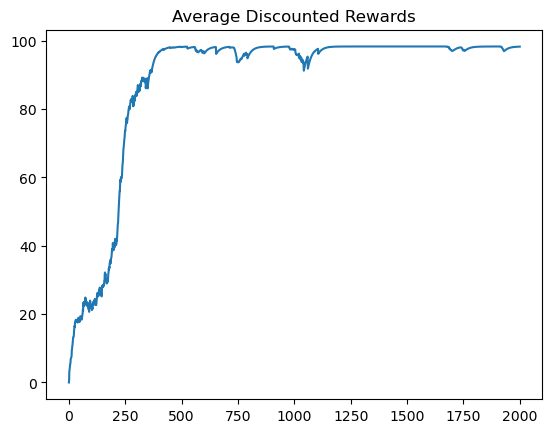

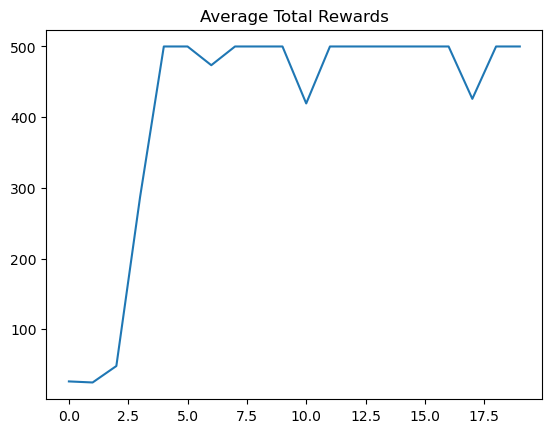

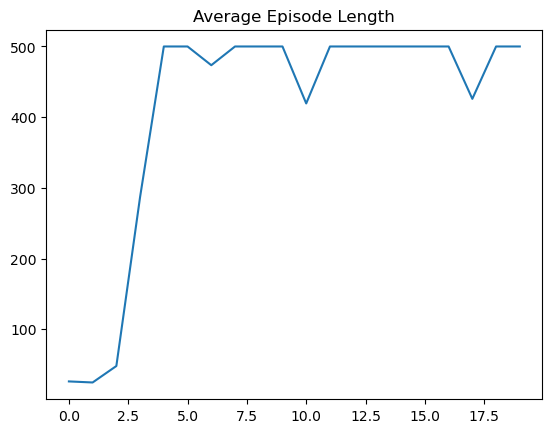

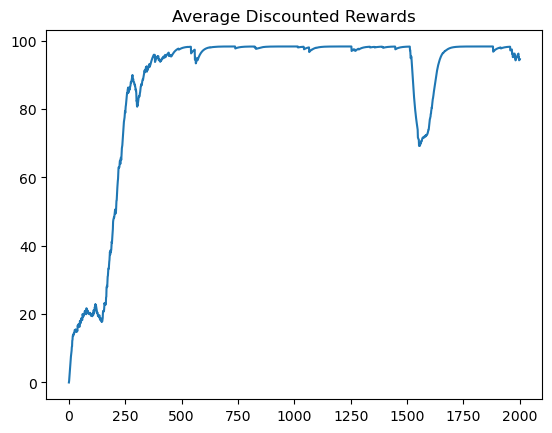

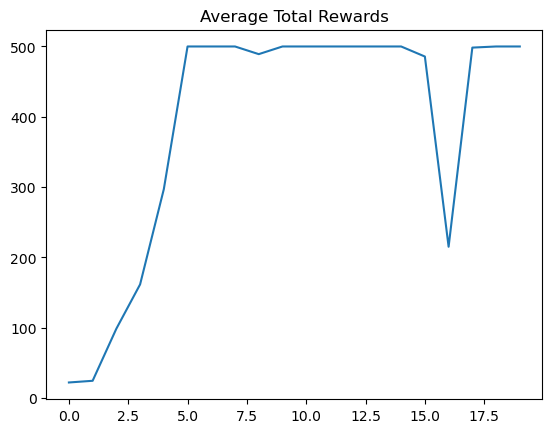

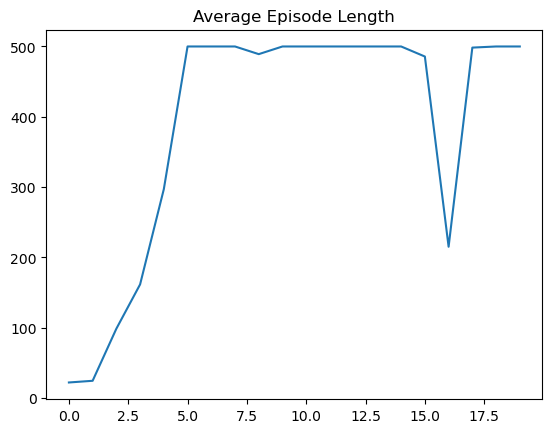

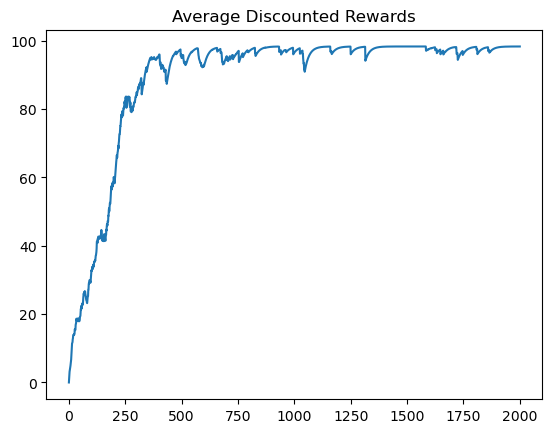

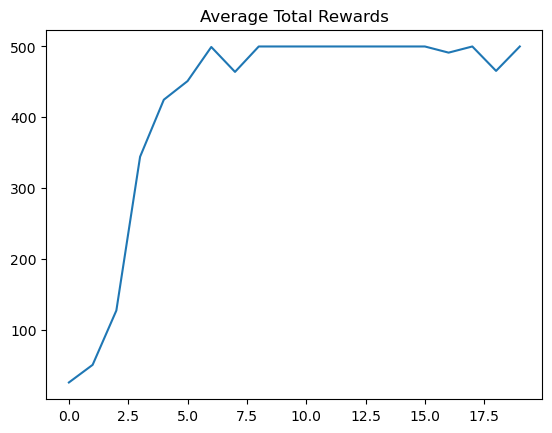

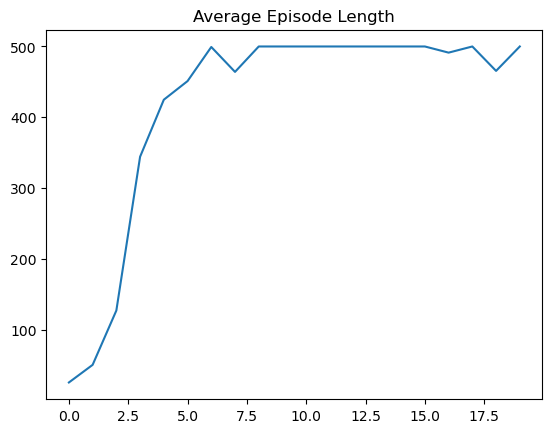

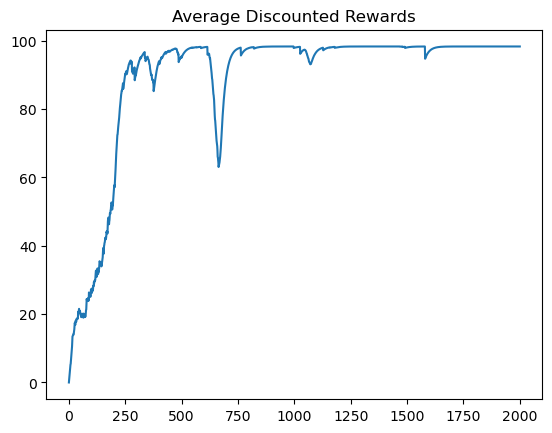

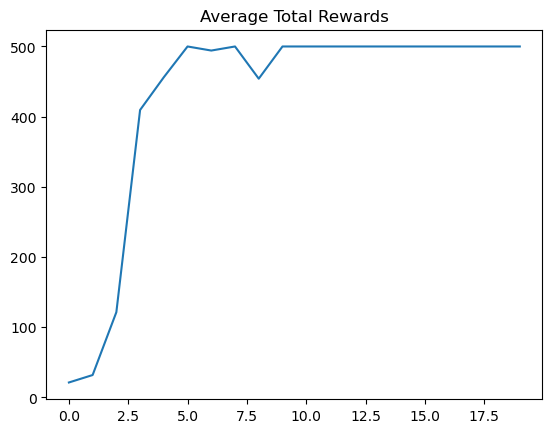

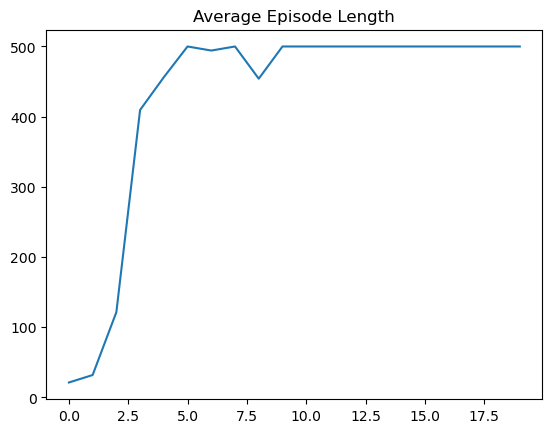

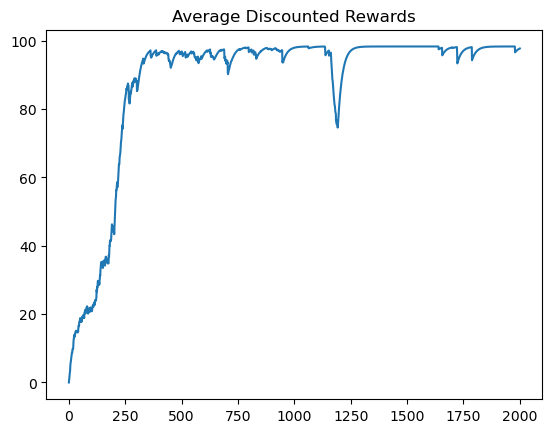

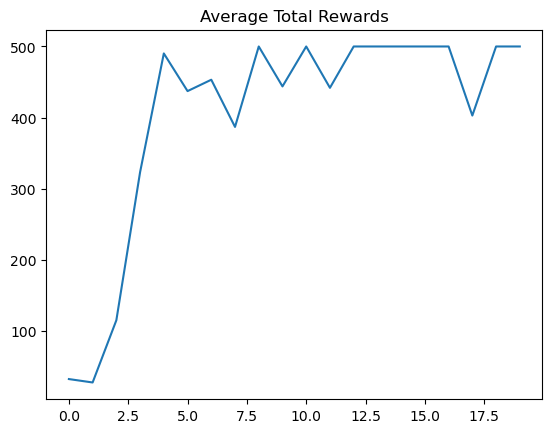

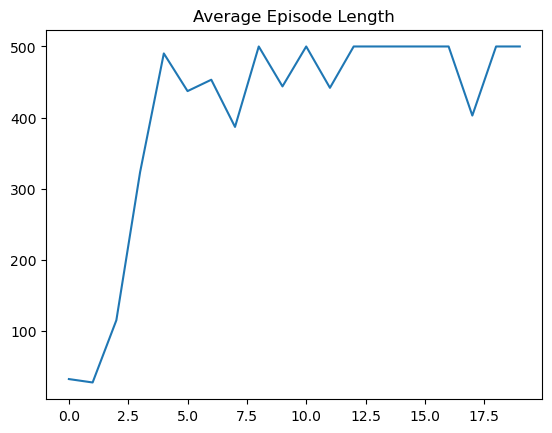

<Figure size 640x480 with 0 Axes>

In [12]:
for i in range(n_run):

    #Instantiate a rendering and a non rendering environment
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Final",
          # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
          name=f"ReinforceAvg",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE_AVG",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10})
    
    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"])

    # Train the agent.
    r = ReinforceAvg(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"])
    (total, average, length) = r.reinforce()

    plt.plot(total)
    plt.title('Average Discounted Rewards')
    plt.figure()
    plt.plot(average)
    plt.title('Average Total Rewards')
    plt.figure()
    plt.plot(length)
    plt.title('Average Episode Length')
    plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

#usare temperatura nel softmax per evitare crolli
#provare anche a diminuire hidden layer size
#di solito non si riportano le curve, data la natura stocastica -> 5 seed e poi riportare curva media e bande di confidenza

In [13]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards) = r.run_episode(display=True, test=True) #deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

### wandb ReinforceAvg Report
Add Comments (ricordarsi di dire che average reward e average length sono la stessa cosa)

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

### ReinforceStd
This class extends ReinforceAvg. 
The attribute baseline has been added to specify whether we want no baseline or a standardization baseline.
The method reinforce has been overridden to implement the distinction between standardization and no baseline.

In [6]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.

class ReinforceStd(ReinforceAvg):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10, baseline=None):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, max_len, N, eval_episodes)
        self.baseline = baseline

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # Choose between standardization baseline or no baseline
        if self.baseline == 'std':
            print('Training agent with standardization baseline.')
        else:
            print('Training agent with no baseline.')

        # Track episode rewards, average rewards and average lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0].item() + 0.95 * running_rewards[-1]
            running_rewards.append(running_reward)

            # Handle baseline.
            if self.baseline == 'std':
                target = (returns - returns.mean()) / returns.std()
            else:
                target = returns

            # Make an optimization step
            opt.zero_grad()

            # Update policy network
            loss = (-log_probs * target).mean()
            loss.backward()
            opt.step()

            metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
            wandb.log({**metrics})

            # Render an episode after every 100 policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length) = self.run_episode(display=True)
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _) = self.run_episode()
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        return (running_rewards, average_rewards, average_lengths)

### ReinforceStd runs

Training agent with no baseline.
Average Total: 27.8
Average Length: 27.8
Running reward: 0.6497082233428956
Average Total: 30.7
Average Length: 30.7
Running reward: 29.53992215141318
Average Total: 74.0
Average Length: 74.0
Running reward: 46.26289022237203
Average Total: 153.6
Average Length: 153.6
Running reward: 75.61212659911843
Average Total: 116.9
Average Length: 116.9
Running reward: 74.37100625441774
Average Total: 92.7
Average Length: 92.7
Running reward: 58.508833311131404
Average Total: 335.3
Average Length: 335.3
Running reward: 87.97727831735277
Average Total: 108.6
Average Length: 108.6
Running reward: 53.75278495956212
Average Total: 280.4
Average Length: 280.4
Running reward: 88.72105167481122
Average Total: 408.9
Average Length: 408.9
Running reward: 82.42567101850189
Average Total: 487.4
Average Length: 487.4
Running reward: 94.34569772566272
Average Total: 373.7
Average Length: 373.7
Running reward: 85.11857107461013
Average Total: 178.2
Average Length: 178.2
Runnin

Average Length,▁▁▂▃▂▂▆▂▅▇█▆▃▆▂▂▃███
Average Total Reward,▁▁▂▃▂▂▆▂▅▇█▆▃▆▂▂▃███
Policy Loss,▄▄▄▅▃▆██▇▇▅█████▆▇▅▅▅██▇▁▅▂▅▃▁▇▄▇▆▄▄▄▅▄▄
Running Reward,▁▂▃▃▄▆▆▇▆▅▄▄▇▄▅▆▇▇▇██▇▆▇▄▄▃▅▃▃▅▇▆▇██████
Average Length,493.3
Average Total Reward,493.3
Policy Loss,9.73129
Running Reward,98.33046


Training agent with no baseline.
Average Total: 19.7
Average Length: 19.7
Running reward: 0.42808961868286133
Average Total: 35.5
Average Length: 35.5
Running reward: 24.59972676149144
Average Total: 37.0
Average Length: 37.0
Running reward: 21.38337121811648
Average Total: 29.1
Average Length: 29.1
Running reward: 28.689609137156
Average Total: 40.2
Average Length: 40.2
Running reward: 27.82999648753389
Average Total: 98.5
Average Length: 98.5
Running reward: 50.662315082860495
Average Total: 122.5
Average Length: 122.5
Running reward: 63.5343813934698
Average Total: 145.9
Average Length: 145.9
Running reward: 75.0308118375735
Average Total: 201.0
Average Length: 201.0
Running reward: 81.99535565602594
Average Total: 360.7
Average Length: 360.7
Running reward: 93.04471260222601
Average Total: 237.1
Average Length: 237.1
Running reward: 87.47877076005636
Average Total: 113.6
Average Length: 113.6
Running reward: 72.0247274965212
Average Total: 91.5
Average Length: 91.5
Running reward: 

Average Length,▁▁▁▁▁▂▃▃▄▆▄▃▂▄▇▆█▇▄▃
Average Total Reward,▁▁▁▁▁▂▃▃▄▆▄▃▂▄▇▆█▇▄▃
Policy Loss,▃▂▃▅▃▁▃▁▅▇▇▇▇▇████▆▇▇▆▆▇▇▇▇▇▄▄▃▃▄▆▆▆▆▅▄▆
Running Reward,▁▂▂▂▂▂▃▃▃▄▅▅▅▇▆▆▇▇█▇▇▆▆▆▅▅▇▇█████▇▆▇▆▅▆▆
Average Length,115.6
Average Total Reward,115.6
Policy Loss,11.66318
Running Reward,75.8727


Training agent with no baseline.
Average Total: 29.2
Average Length: 29.2
Running reward: 1.0608932495117187
Average Total: 36.2
Average Length: 36.2
Running reward: 27.882312256873128
Average Total: 62.3
Average Length: 62.3
Running reward: 45.64124196614101
Average Total: 109.0
Average Length: 109.0
Running reward: 70.43792360422877
Average Total: 176.0
Average Length: 176.0
Running reward: 72.95222459672013
Average Total: 347.2
Average Length: 347.2
Running reward: 92.57803219265288
Average Total: 137.6
Average Length: 137.6
Running reward: 71.67277740544338
Average Total: 162.5
Average Length: 162.5
Running reward: 73.67966475471793
Average Total: 82.9
Average Length: 82.9
Running reward: 72.68455077377065
Average Total: 161.8
Average Length: 161.8
Running reward: 74.64397321896188
Average Total: 463.5
Average Length: 463.5
Running reward: 82.50029716235503
Average Total: 258.5
Average Length: 258.5
Running reward: 80.11907975425724
Average Total: 500.0
Average Length: 500.0
Runnin

Average Length,▁▁▁▂▃▆▃▃▂▃▇▄█▃███▇██
Average Total Reward,▁▁▁▂▃▆▃▃▂▃▇▄█▃███▇██
Policy Loss,▃▁▃▄▆█▅▇▅▄▇▇▆▆▇▄▅▇▆▆▆▆▄▃▃▄▅▇▄▅▄▄▅▄▄▄▄▄▄▃
Running Reward,▁▂▂▃▄▆▅▅▇▇█▆▆▅▆█▅▆▆▆▇▆▇███▆▇████████████
Average Length,500.0
Average Total Reward,500.0
Policy Loss,14.26439
Running Reward,90.16166


Training agent with no baseline.
Average Total: 21.7
Average Length: 21.7
Running reward: 0.7774312019348145
Average Total: 46.4
Average Length: 46.4
Running reward: 32.97108315924673
Average Total: 50.1
Average Length: 50.1
Running reward: 41.85201160344572
Average Total: 62.4
Average Length: 62.4
Running reward: 40.192796565445285
Average Total: 87.6
Average Length: 87.6
Running reward: 50.23298715406475
Average Total: 109.1
Average Length: 109.1
Running reward: 61.95077786986402
Average Total: 202.3
Average Length: 202.3
Running reward: 79.21395509448331
Average Total: 500.0
Average Length: 500.0
Running reward: 95.03111986021935
Average Total: 197.1
Average Length: 197.1
Running reward: 83.8598592107853
Average Total: 500.0
Average Length: 500.0
Running reward: 97.16353505044702
Average Total: 145.7
Average Length: 145.7
Running reward: 84.43984700205073
Average Total: 113.6
Average Length: 113.6
Running reward: 65.93053674279581
Average Total: 121.0
Average Length: 121.0
Running r

Average Length,▁▁▁▂▂▂▄█▄█▃▂▂██████▅
Average Total Reward,▁▁▁▂▂▂▄█▄█▃▂▂██████▅
Policy Loss,▂▆▇▅█▂▅▅▄▄▄▆▄▄▂▄▅▂▁▂▅▂▃▂▂▄▁▂▁▂▁▁▁▃▂▂▁▂▄▆
Running Reward,▁▂▃▃▃▂▄▄▄▅▅▅▆▇█▇▇███▆▆▅▅▆▇████████████▇▆
Average Length,321.8
Average Total Reward,321.8
Policy Loss,11.50853
Running Reward,70.47747


Training agent with no baseline.
Average Total: 19.5
Average Length: 19.5
Running reward: 0.7774312019348145
Average Total: 59.3
Average Length: 59.3
Running reward: 30.484148345100046
Average Total: 79.9
Average Length: 79.9
Running reward: 45.574372554984315
Average Total: 201.9
Average Length: 201.9
Running reward: 78.63867972748072
Average Total: 84.0
Average Length: 84.0
Running reward: 60.22816248115648
Average Total: 436.1
Average Length: 436.1
Running reward: 94.00898005524735
Average Total: 379.0
Average Length: 379.0
Running reward: 93.02146027243651
Average Total: 129.6
Average Length: 129.6
Running reward: 68.06212121917586
Average Total: 116.6
Average Length: 116.6
Running reward: 69.08403239241424
Average Total: 355.2
Average Length: 355.2
Running reward: 77.01223337712446
Average Total: 100.3
Average Length: 100.3
Running reward: 63.66515514020587
Average Total: 146.5
Average Length: 146.5
Running reward: 72.42894453774616
Average Total: 315.4
Average Length: 315.4
Runni

Average Length,▁▂▂▄▂▇▆▃▂▆▂▃▅▄▂▆█▂▂▃
Average Total Reward,▁▂▂▄▂▇▆▃▂▆▂▃▅▄▂▆█▂▂▃
Policy Loss,▆▂▃▅▂██▆▅▄▄▆█▆▃▇▇▆▆▅▇▆▇▅▄▅▆▆▅█▃▃▅▆▁▅▃▇▇▅
Running Reward,▁▂▃▃▄▆▇▇▄▇██▇▅▅▆▆▅▇▆▅▅▆▇▇▇▆▇▅▃▇██▇▅▄▆▇▇▆
Average Length,126.6
Average Total Reward,126.6
Policy Loss,10.47163
Running Reward,82.59881


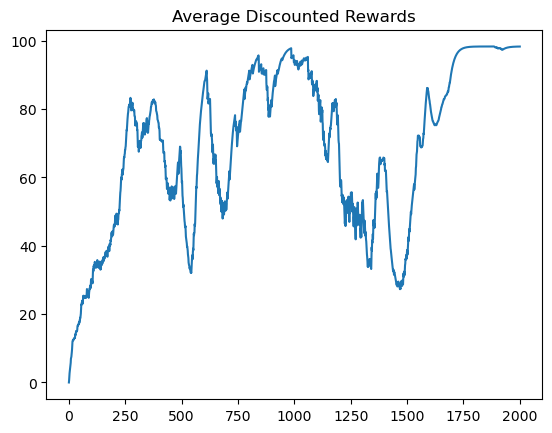

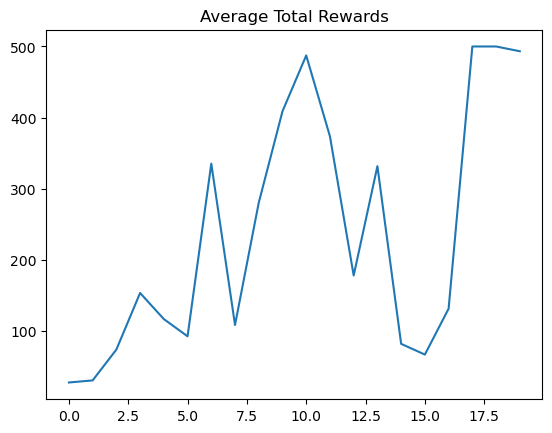

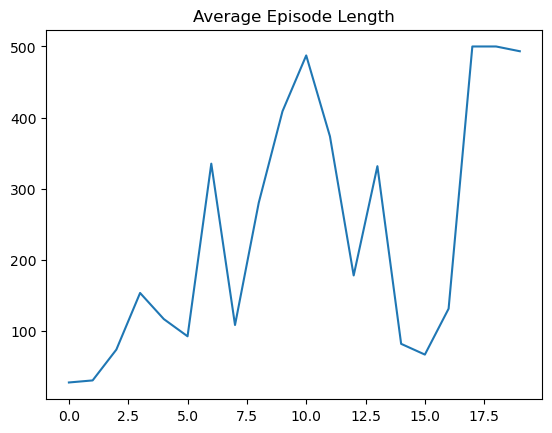

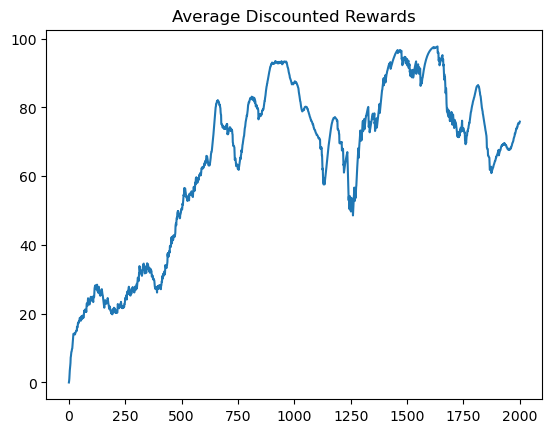

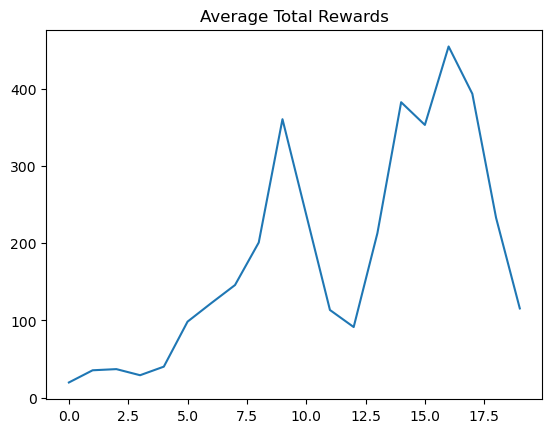

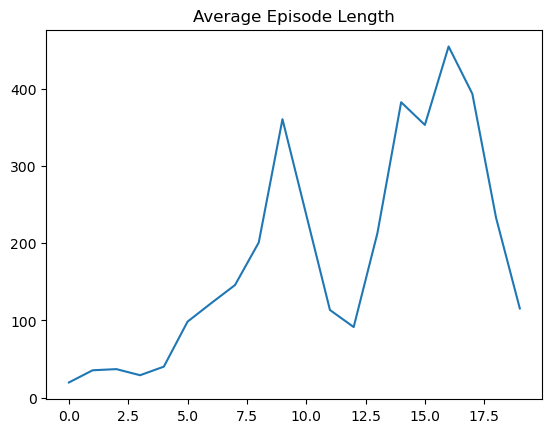

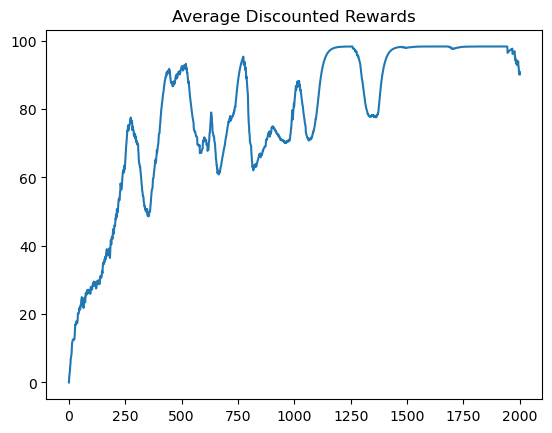

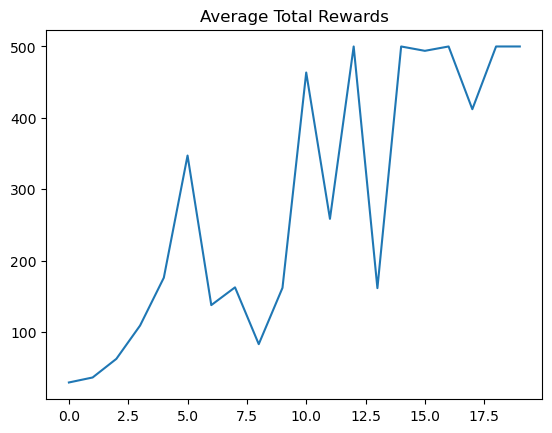

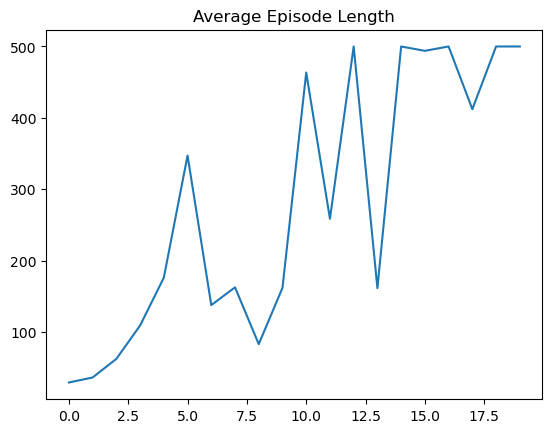

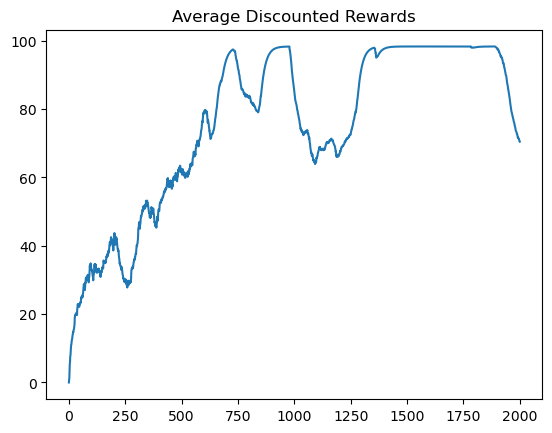

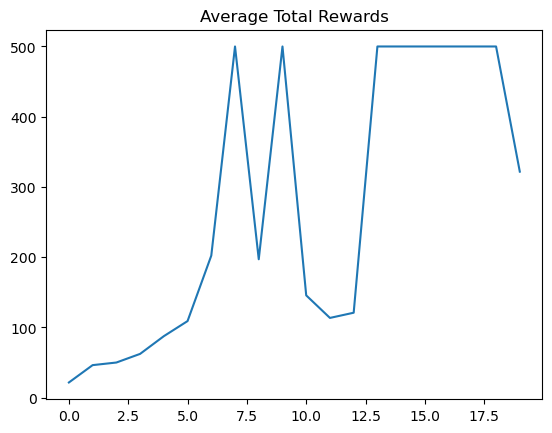

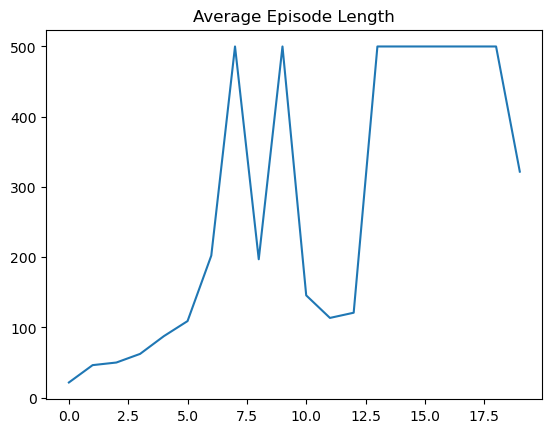

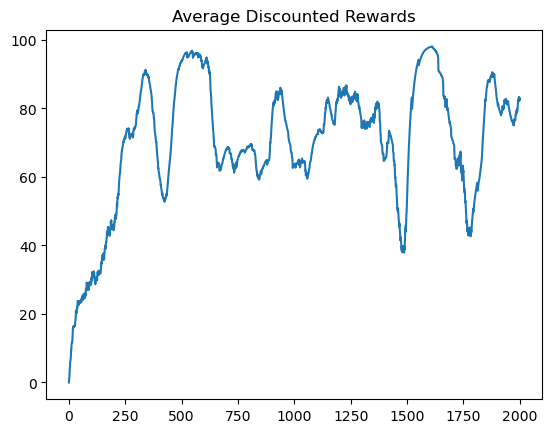

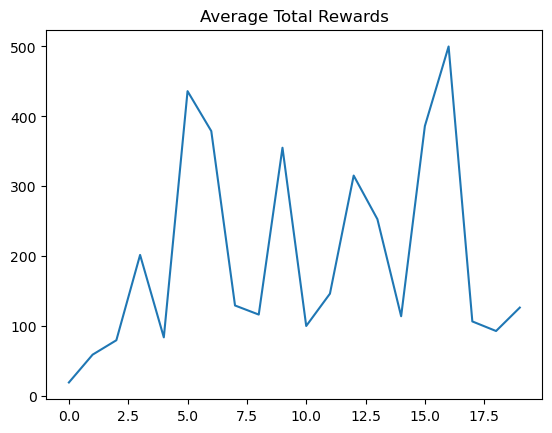

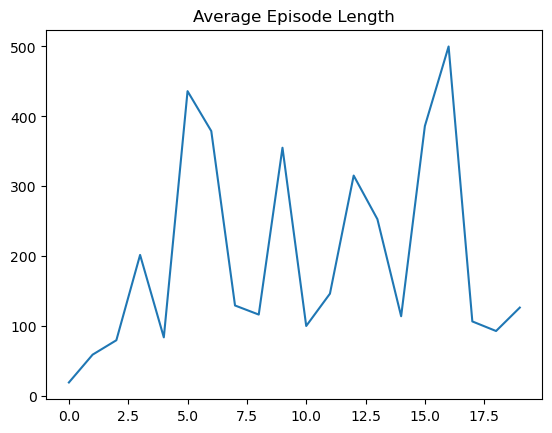

<Figure size 640x480 with 0 Axes>

In [18]:
for i in range(n_run):

    # Instantiate a rendering and a non-rendering environment.
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Final",
          # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
          name=f"ReinforceStd",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "architecture": "REINFORCE_STD",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10,
          "baseline": None})
    
    # Make a policy network.
    policy = PolicyNet(env, T=run.config["temperature"])

    # Train the agent.
    r = ReinforceStd(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"], baseline=run.config["baseline"])
    (total, average, length) = r.reinforce()

    plt.plot(total)
    plt.title('Average Discounted Rewards')
    plt.figure()
    plt.plot(average)
    plt.title('Average Total Rewards')
    plt.figure()
    plt.plot(length)
    plt.title('Average Episode Length')
    plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [ ]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards) = r.run_episode(display=True, test=True) #deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

### wandb ReinfoceStd Report
Add comments

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

### Baseline Network
A simple network with the same architecture as the Policy Net that has to learn to estimate the value function.

In [ ]:
class BaselineNet(nn.Module):
    def __init__(self, env, inner_size=128):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner_size)
        self.fc2 = nn.Linear(inner_size, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

### ReinfoceBas
The class extends ReinforceStd. Since we are now also considering baselines that can be neural networks, an additional attribute, lrb, has been added to indicate the learning rate of the Baseline Network. The methods select_action, run_episode and reinforce have been overridden to implement the eventual utilize of a Baseline Network.

If there is a baseline, the policy loss, that is used to optimize the policy, is calculated with the target value. If the baseline is a Neural Network it is also optimized using its loss (how closely it approximates the value function).

In [7]:
class ReinforceBas(ReinforceStd):
    def __init__(self, policy, env, env_render=None, gamma=0.99, num_episodes=10, lr=1e-2,
                 max_len=500, N=100, eval_episodes=10, baseline=None, lrb=1e-2):
        super().__init__(policy, env, env_render, gamma, num_episodes, lr, 
                         max_len, N, eval_episodes, baseline)
        self.learning_rate_baseline = lrb

    def select_action(self, obs):
        value = self.baseline(obs)
        value.compute_grad = True
        dist = Categorical(self.policy(obs))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1), value)

    # Given an environment and a policy, run it up to the maximum number of steps.
    def run_episode(self, display=False, test=False):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []
        values = []
        env = self.environment
        if display:
            env = self.env_render

        # Reset the environment and start the episode.
        (obs, info) = env.reset()
        for i in range(self.max_len):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            if test:
                (action, log_prob) = self.select_max_action(obs)
            else:
                (action, log_prob, value) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)
            values.append(value)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        length = i + 1
        return (observations, actions, torch.cat(log_probs), rewards, length, values)

    def reinforce(self):
        # We use Adam instead of SGD.
        opt = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)

        # If we have a baseline network, create the optimizer.
        if isinstance(self.baseline, nn.Module):
            opt_baseline = torch.optim.Adam(self.baseline.parameters(), lr=self.learning_rate_baseline)
            self.baseline.train()
            print('Training agent with baseline value network.')
        elif self.baseline == 'std':
            print('Training agent with standardization baseline.')
        else:
            print('Training agent with no baseline.')

        # Track episode rewards, average rewards and average episode lengths in 3 lists.
        running_rewards = [0.0]
        average_rewards = []
        average_lengths = []

        # The main training loop.
        self.policy.train()
        for episode in range(self.num_episodes):
            # Run an episode of the environment, collect everything needed for policy update.
            (observations, actions, log_probs, rewards, length, values) = self.run_episode()

            # Compute the discounted reward for every step of the episode.
            returns = torch.tensor(self.compute_returns(rewards), dtype=torch.float32)
            values =  torch.cat(values)

            # Keep a running average of total discounted rewards for the whole episode.
            running_reward = 0.05 * returns[0] + 0.95 * running_rewards[-1]
            wandb.log({"Reward": running_reward})
            running_rewards.append(running_reward)

            # Handle baseline.
            if isinstance(self.baseline, nn.Module):
                with torch.no_grad():
                    target = returns - values
            elif self.baseline == 'std':
                target = (returns - returns.mean()) / returns.std()
            else:
                target = returns

            # Make an optimization step
            opt.zero_grad()

            # Update policy network
            loss = (-log_probs * target).mean()
            loss.backward()
            opt.step()

            # Update baseline network.
            if isinstance(self.baseline, nn.Module):
                loss_baseline = F.mse_loss(values, returns)
                opt_baseline.zero_grad()
                loss_baseline.backward()
                opt_baseline.step()

                metrics = {"Policy Loss": loss,
                           "Running Reward": running_reward,
                           "Baseline Loss": loss_baseline}
            else:
              metrics = {"Policy Loss": loss,
                         "Running Reward": running_reward}

            wandb.log({**metrics})

            # Render an episode after every 100 policy updates.
            if not episode % self.N:
                self.policy.eval()
                total_reward = 0
                total_length = 0
                for _ in range(self.M):
                    (_, _, _, rewards, length, values) = self.run_episode()
                    total_reward += np.sum(rewards)
                    total_length += length
                average_reward = total_reward / self.M
                average_rewards.append(average_reward)
                print(f'Average Total: {average_reward}')
                average_length = total_length / self.M
                average_lengths.append(average_length)
                print(f'Average Length: {average_length}')

                val_metrics = {"Average Total Reward": average_reward,
                               "Average Length": average_length}
                wandb.log({**val_metrics})

                (obs, _, _, _, _, _) = self.run_episode(display=True)
                self.policy.train()
                print(f'Running reward: {running_rewards[-1]}')

        # Return the running rewards.
        self.policy.eval()
        if isinstance(self.baseline, nn.Module):
            self.baseline.eval()
        return (running_rewards, average_rewards, average_lengths)

### ReinforceBas runs

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Training agent with baseline value network.
Average Total: 19.8
Average Length: 19.8
Running reward: 0.9013606905937195
Average Total: 62.3
Average Length: 62.3
Running reward: 35.71567916870117
Average Total: 288.6
Average Length: 288.6
Running reward: 82.64091491699219
Average Total: 171.9
Average Length: 171.9
Running reward: 83.66920471191406
Average Total: 424.3
Average Length: 424.3
Running reward: 94.18891906738281
Average Total: 438.0
Average Length: 438.0
Running reward: 94.77143859863281
Average Total: 474.6
Average Length: 474.6
Running reward: 94.41165161132812
Average Total: 500.0
Average Length: 500.0
Running reward: 98.29573822021484
Average Total: 500.0
Average Length: 500.0
Running reward: 98.30813598632812
Average Total: 500.0
Average Length: 500.0
Running reward: 97.17845153808594
Average Total: 310.0
Average Length: 310.0
Running reward: 94.20506286621094
Average Total: 470.4
Average Length: 470.4
Running reward: 98.00032043457031
Average Total: 500.0
Average Length

Average Length,▁▂▅▃▇▇████▅█████████
Average Total Reward,▁▂▅▃▇▇████▅█████████
Avg_length,▁▂▅▃▇▇████▅█████████
Avg_total_reward,▁▂▅▃▇▇████▅█████████
Baseline Loss,▁▁▂▃▃▂▄▅▁▄▄▆▄▄▆▅▄▄▄▄▃▅▅█▅▅▄▃▃▅▅▆▃▆▄▂▂▁▁▅
Loss_baseline,▁▁▂▃▃▂▄▅▁▄▄▆▄▄▆▅▄▄▄▄▃▅▅█▅▅▄▃▃▅▅▆▃▆▄▂▂▁▁▅
Policy Loss,▅▅▄▄▇▆▄▅▆▅▅▆▄█▁▅▃▄▄█▅▄▃▇▄▄▆▅▅▄█▆▄▃▅▄▅▆▆▂
Reward,▁▂▃▅▇█▇█████████████████████████████████
Running Reward,▁▂▃▅▇█▇█████████████████████████████████
Average Length,500.0
Average Total Reward,500.0


Training agent with baseline value network.
Average Total: 18.4
Average Length: 18.4
Running reward: 0.6927111744880676
Average Total: 73.6
Average Length: 73.6
Running reward: 40.506385803222656
Average Total: 307.5
Average Length: 307.5
Running reward: 89.65240478515625
Average Total: 278.2
Average Length: 278.2
Running reward: 93.06902313232422
Average Total: 304.7
Average Length: 304.7
Running reward: 91.0772705078125
Average Total: 448.6
Average Length: 448.6
Running reward: 98.23312377929688
Average Total: 497.5
Average Length: 497.5
Running reward: 97.69771575927734
Average Total: 420.9
Average Length: 420.9
Running reward: 96.97297668457031
Average Total: 480.9
Average Length: 480.9
Running reward: 97.50335693359375
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33431243896484
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33826446533203
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33970642089844
Average Total: 398.4
Average Length

Average Length,▁▂▅▅▅▇█▇████▇████▆██
Average Total Reward,▁▂▅▅▅▇█▇████▇████▆██
Avg_length,▁▂▅▅▅▇█▇████▇████▆██
Avg_total_reward,▁▂▅▅▅▇█▇████▇████▆██
Baseline Loss,▁▁▂▅▃▃▃█▃▅▄▄▂▁▁▁▁▃▂▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▇▁▁▁
Loss_baseline,▁▁▂▅▃▃▃█▃▅▄▄▂▁▁▁▁▃▂▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▇▁▁▁
Policy Loss,█▆▃▄█▅▅▁▅▄█▇▆▇▄▇▄▃▄▁▆▄▇▆▆▅▅▆▆▇▆▄█▆▇▅▃▇▆▅
Reward,▁▂▄▆▇███████████████████████████████████
Running Reward,▁▂▄▆▇███████████████████████████████████
Average Length,483.1
Average Total Reward,483.1


Training agent with baseline value network.
Average Total: 22.7
Average Length: 22.7
Running reward: 1.5372270345687866
Average Total: 47.3
Average Length: 47.3
Running reward: 33.41548538208008
Average Total: 228.6
Average Length: 228.6
Running reward: 82.03673553466797
Average Total: 475.1
Average Length: 475.1
Running reward: 92.33216094970703
Average Total: 498.9
Average Length: 498.9
Running reward: 95.07272338867188
Average Total: 471.4
Average Length: 471.4
Running reward: 97.13124084472656
Average Total: 488.0
Average Length: 488.0
Running reward: 97.64773559570312
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33859252929688
Average Total: 489.1
Average Length: 489.1
Running reward: 97.53997039794922
Average Total: 500.0
Average Length: 500.0
Running reward: 98.33711242675781
Average Total: 500.0
Average Length: 500.0
Running reward: 98.2085189819336
Average Total: 500.0
Average Length: 500.0
Running reward: 98.28660583496094
Average Total: 500.0
Average Length:

Average Length,▁▁▄█████████████████
Average Total Reward,▁▁▄█████████████████
Avg_length,▁▁▄█████████████████
Avg_total_reward,▁▁▄█████████████████
Baseline Loss,▁▁▅▅▃▂▄▄▃▄▃▃▄▄▅▂▄▂▄▃▃▁▁▂▃▃▁▂▃▂▁▂█▄▃▃▅▃▂▂
Loss_baseline,▁▁▅▅▃▂▄▄▃▄▃▃▄▄▅▂▄▂▄▃▃▁▁▂▃▃▁▂▃▂▁▂█▄▃▃▅▃▂▂
Policy Loss,▆▇█▆▇▆▆▅▃▆▆▆▇▆▆▄▅▆▅▅▇▅▇▆▆▇▇▆▆▅▅█▁▅▇▅▇▇▅▅
Reward,▁▂▃▅▇▇██████████████████████████████████
Running Reward,▁▂▃▅▇▇██████████████████████████████████
Average Length,500.0
Average Total Reward,500.0


Training agent with baseline value network.
Average Total: 23.2
Average Length: 23.2
Running reward: 1.605141282081604
Average Total: 63.4
Average Length: 63.4
Running reward: 35.129268646240234
Average Total: 224.3
Average Length: 224.3
Running reward: 82.71160888671875
Average Total: 125.0
Average Length: 125.0
Running reward: 81.24261474609375
Average Total: 500.0
Average Length: 500.0
Running reward: 97.71341705322266
Average Total: 356.4
Average Length: 356.4
Running reward: 95.07432556152344
Average Total: 500.0
Average Length: 500.0
Running reward: 98.03118896484375
Average Total: 500.0
Average Length: 500.0
Running reward: 98.11455535888672
Average Total: 500.0
Average Length: 500.0
Running reward: 98.34513854980469
Average Total: 500.0
Average Length: 500.0
Running reward: 98.26264953613281
Average Total: 500.0
Average Length: 500.0
Running reward: 98.34892272949219
Average Total: 500.0
Average Length: 500.0
Running reward: 98.2593002319336
Average Total: 480.6
Average Length:

Average Length,▁▂▄▂█▆██████████████
Average Total Reward,▁▂▄▂█▆██████████████
Avg_length,▁▂▄▂█▆██████████████
Avg_total_reward,▁▂▄▂█▆██████████████
Baseline Loss,▁▂▂▂▃▅▃▄▅▅▄▄▅▂▂▄▇▃▃▄▄▅▄▁▅▆▆▃▂█▅▄▆▄▂▂▂▁▁▁
Loss_baseline,▁▂▂▂▃▅▃▄▅▅▄▄▅▂▂▄▇▃▃▄▄▅▄▁▅▆▆▃▂█▅▄▆▄▂▂▂▁▁▁
Policy Loss,▄▅▄▄▅▁▄▆▃▃▃▄▃▃▄▃█▃▄▄▄▆▅▄▆▃▅▃▅▁▂▃▃▄▄▃▅▄▃▄
Reward,▁▂▃▅▇█▇████████████████████▇████████████
Running Reward,▁▂▃▅▇█▇████████████████████▇████████████
Average Length,500.0
Average Total Reward,500.0


Training agent with baseline value network.
Average Total: 19.9
Average Length: 19.9
Running reward: 0.8604653477668762
Average Total: 70.5
Average Length: 70.5
Running reward: 32.419822692871094
Average Total: 413.3
Average Length: 413.3
Running reward: 93.0123519897461
Average Total: 425.7
Average Length: 425.7
Running reward: 94.19913482666016
Average Total: 476.5
Average Length: 476.5
Running reward: 97.46856689453125
Average Total: 500.0
Average Length: 500.0
Running reward: 97.91087341308594
Average Total: 500.0
Average Length: 500.0
Running reward: 98.11099243164062
Average Total: 500.0
Average Length: 500.0
Running reward: 97.78511810302734
Average Total: 369.6
Average Length: 369.6
Running reward: 96.93196868896484
Average Total: 500.0
Average Length: 500.0
Running reward: 96.22102355957031
Average Total: 424.8
Average Length: 424.8
Running reward: 97.6121826171875
Average Total: 500.0
Average Length: 500.0
Running reward: 98.02599334716797
Average Total: 500.0
Average Length:

Average Length,▁▂▇▇████▆█▇██████▇█▇
Average Total Reward,▁▂▇▇████▆█▇██████▇█▇
Avg_length,▁▂▇▇████▆█▇██████▇█▇
Avg_total_reward,▁▂▇▇████▆█▇██████▇█▇
Baseline Loss,▁▂▂█▃▃▃▅▆▇▄▄▄▃▂▃▁▃▄▃▂▂▃▅▃█▅▄▃▅▂▄▂▁▁▂▁▂▁▁
Loss_baseline,▁▂▂█▃▃▃▅▆▇▄▄▄▃▂▃▁▃▄▃▂▂▃▅▃█▅▄▃▅▂▄▂▁▁▂▁▂▁▁
Policy Loss,▇▆▃▁▆▄▅▃▅▃▅▅▅▃▆▂▆▄█▅▆▄▇▂▂▂▄█▃▂▆█▂▄▄▂▆▆▅▅
Reward,▁▂▃▇████████████▇███████████████████████
Running Reward,▁▂▃▇████████████▇███████████████████████
Average Length,427.0
Average Total Reward,427.0


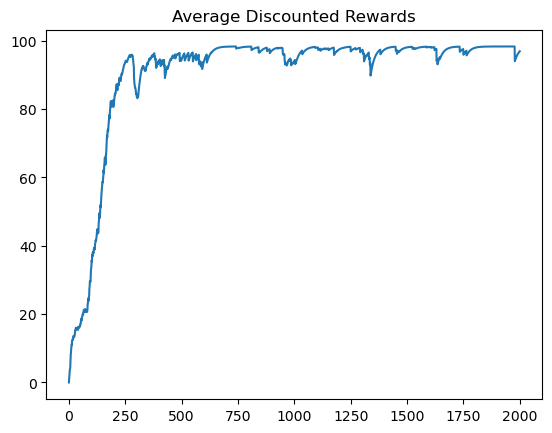

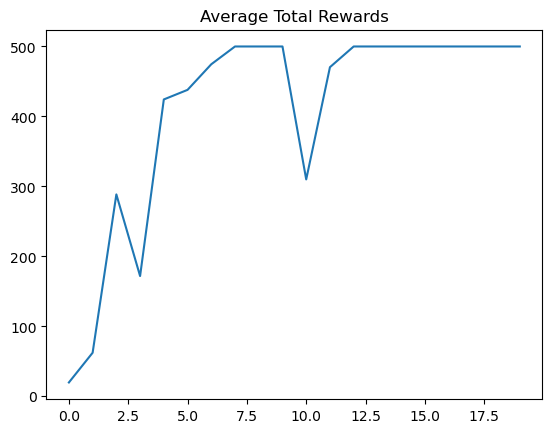

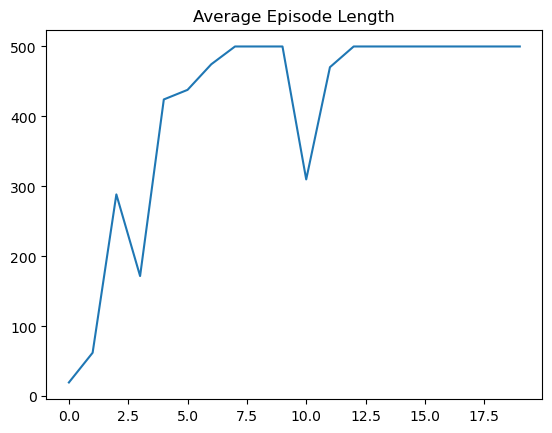

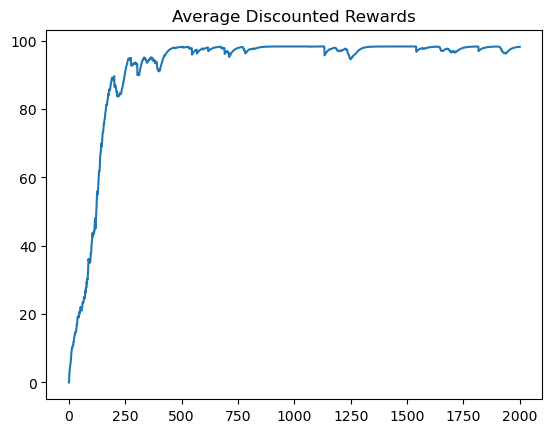

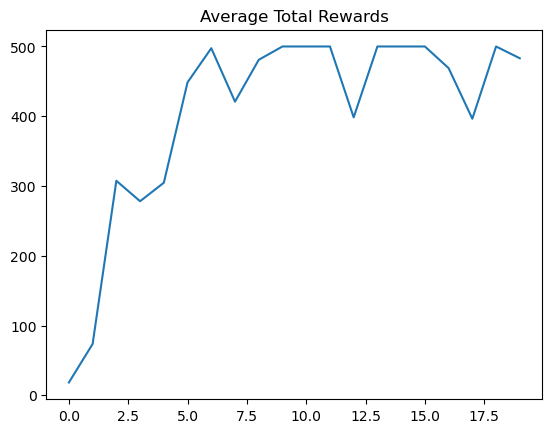

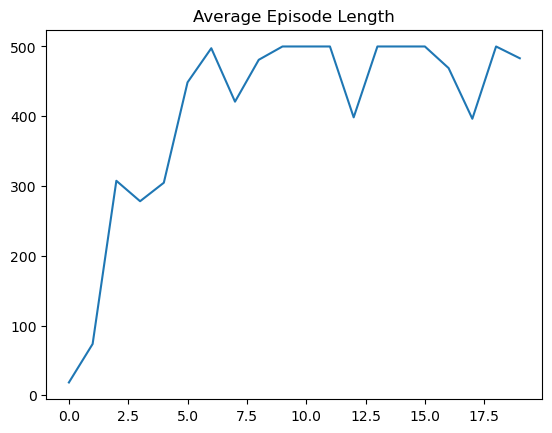

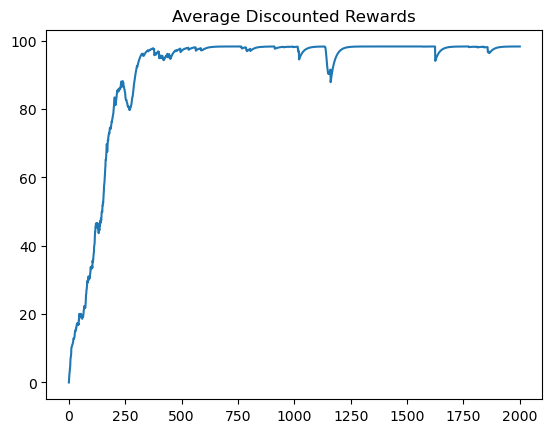

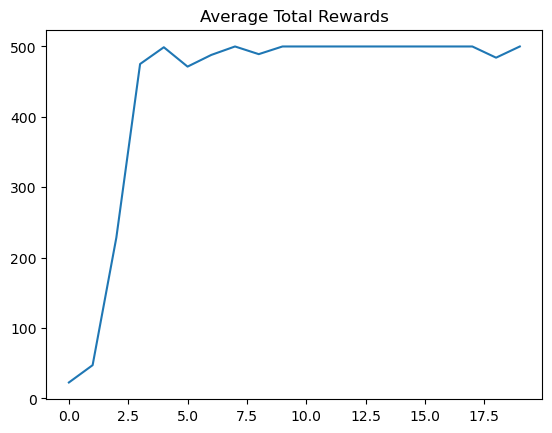

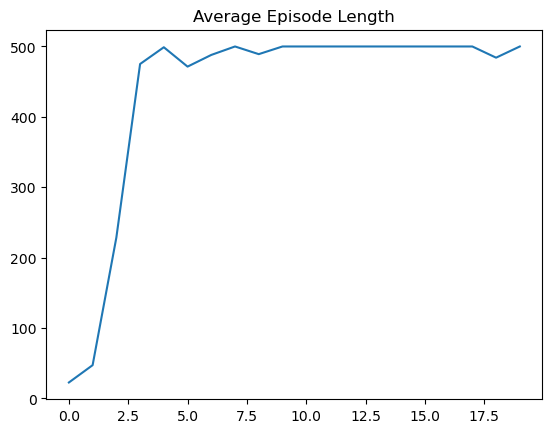

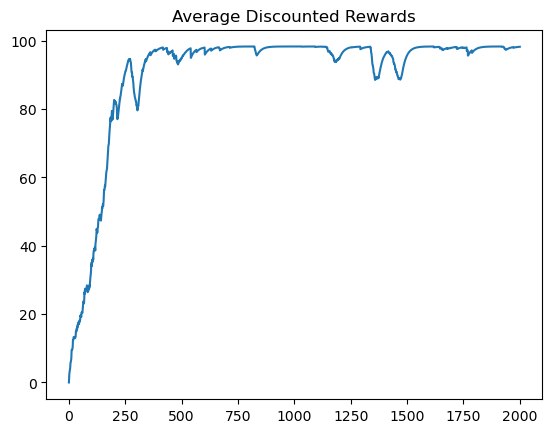

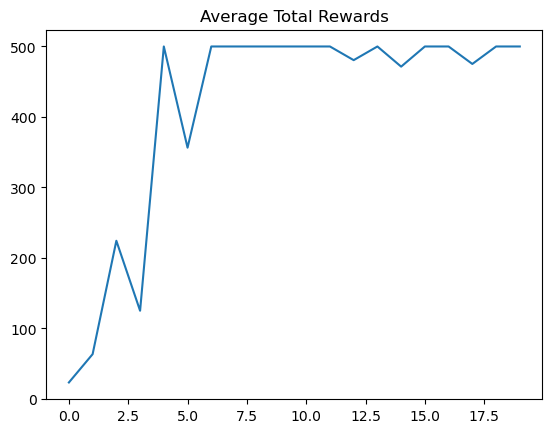

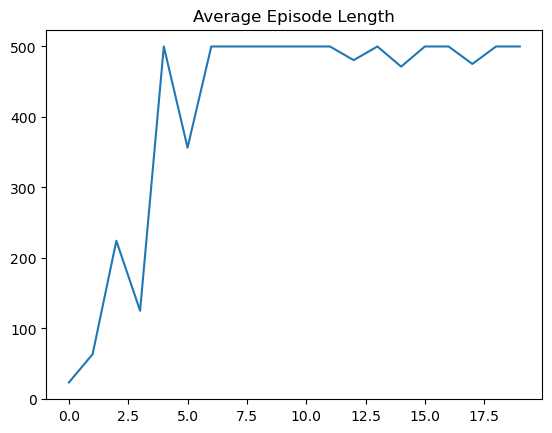

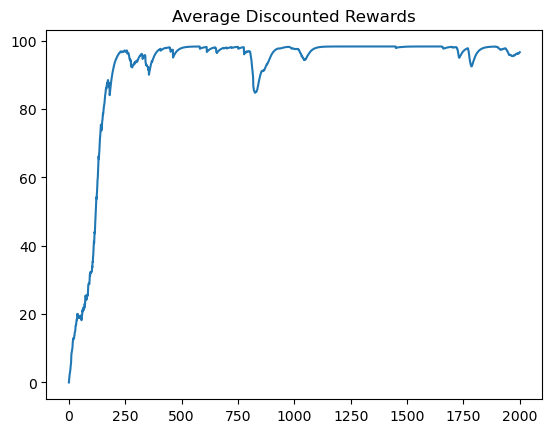

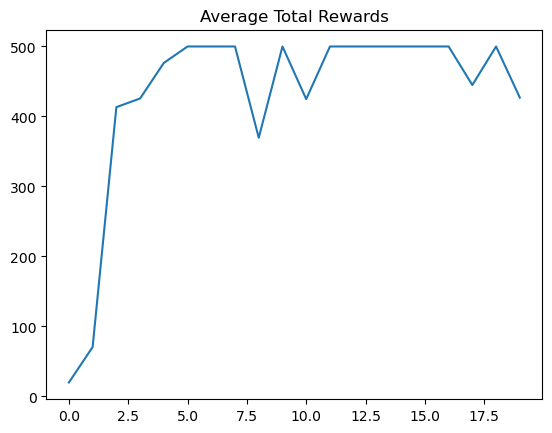

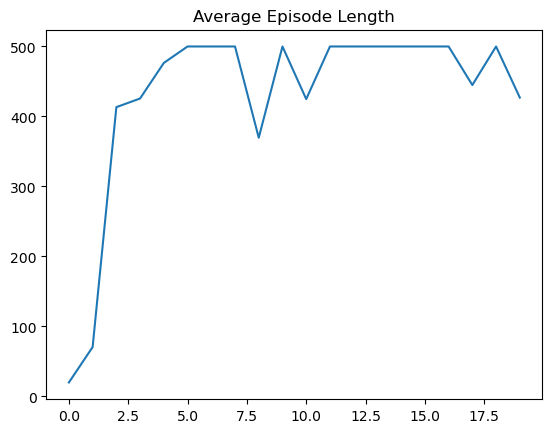

<Figure size 640x480 with 0 Axes>

In [9]:
n_run = 5
seeds = [11, 111, 1111, 11111, 111111]
val_seeds = [22, 222, 22222, 22222, 222222]

for i in range(n_run):

    # Instantiate a rendering and a non-rendering environment.
    env_render = gym.make('CartPole-v1', render_mode='human')
    env = gym.make('CartPole-v1')

    torch.manual_seed(seeds[i])
    env_render.reset(seed = val_seeds[i])
    env.reset(seed = seeds[i])

    run = wandb.init(
          # Set the project where this run will be logged
          project="Lab3-Final",
          # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
          name=f"ReinforceBas",
          # Track hyperparameters and run metadata
          config={
          "learning_rate": 1e-2,
          "baaseline_learning_rate":1e-2,
          "architecture": "REINFORCE_BAS",
          "dataset": "CartPole",
          "episodes": 2000,
          "gamma": 0.99,
          "episode_max_len": 500,
          "N": 100,
          "temperature": 20,
          "M": 10,
          "baseline": "BaselineNet",
          "learning_rate_baseline": 1e-2})

    # Make a policy and a baseline network.
    policy = PolicyNet(env, T=run.config["temperature"])
    baseline = BaselineNet(env)

    # Train the agent.r = ReinforceBas(policy, env, env_render, num_episodes=2000, baseline=baseline)
    r = ReinforceBas(policy, env, env_render, gamma=run.config["gamma"], num_episodes=run.config["episodes"],
                  lr=run.config["learning_rate"], max_len=run.config["episode_max_len"],
                     N=run.config["N"], eval_episodes=run.config["M"], baseline=baseline,
                     lrb=run.config["learning_rate_baseline"])
    (total, average, length) = r.reinforce()

    plt.plot(total)
    plt.title('Average Discounted Rewards')
    plt.figure()
    plt.plot(average)
    plt.title('Average Total Rewards')
    plt.figure()
    plt.plot(length)
    plt.title('Average Episode Length')
    plt.figure()

    wandb.finish()

    # Close up everything
    env_render.close()
    env.close()

In [10]:
# And run the final agent for a few episodes.
env_render = gym.make('CartPole-v1', render_mode='human')
env_render.reset(seed = 100)
r.setEnvRender(env_render)

total_rewards = 0
for _ in range(20):
    (_, _, _, rewards) = r.run_episode(display=True, test=True) #deterministic selected action
    total_rewards += np.sum(rewards)
average_test_reward = total_rewards / 20
print(f'Average reward for episode: {average_test_reward}')
env_render.close()

### wandb ReinforceBas Report
Add comments

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.


In [2]:
#Excercise 3.2
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gymnasium as gym
import gymnasium.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = "cpu"

class DQNet(nn.Module):
    # Policy Network
    def __init__(self, n_obs, n_actions, inner_size=64):
        super(DQNet, self).__init__()
        self.layer1 = nn.Linear(n_obs, inner_size)
        self.layer2 = nn.Linear(inner_size, inner_size)
        self.layer3 = nn.Linear(inner_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    #usare temperatura peggiora i risultati


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.transition = namedtuple("Transition", 
                                     field_names=["observation", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, observation, action, reward, next_state, done):
        t = self.transition(observation, action, reward, next_state, done)
        self.memory.append(t)

    def sample(self):
        transitions = random.sample(self.memory, k=self.batch_size)

        observations = torch.from_numpy(np.vstack([t.observation for t in transitions if t is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([t.action for t in transitions if t is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([t.reward for t in transitions if t is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([t.next_state for t in transitions if t is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([t.done for t in transitions if t is not None]).astype(np.uint8)).float().to(device)

        return (observations, actions, rewards, next_states, dones)

In [3]:
class DQN():
    def __init__(self, n_obs, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step #ogni quanto aggiornare net_target
        self.tau = tau

        # model
        self.net_policy = DQNet(n_obs, n_actions).to(device)
        self.net_target = DQNet(n_obs, n_actions).to(device)
        self.net_target.load_state_dict(self.net_policy.state_dict())
        self.optimizer = optim.Adam(self.net_policy.parameters(), lr=lr) #valutare se usare AdamW
        self.criterion = nn.MSELoss() #valutare se Huber loss

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # reset cycle counter

    def getAction(self, observation, epsilon):
        observation = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        self.net_policy.eval()
        with torch.no_grad():
            action_values = self.net_policy(observation)
        self.net_policy.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, observation, action, reward, next_state, done):
        self.memory.add(observation, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size: #TODO rimuovere quando funzionerà
                transitions = self.memory.sample()
                self.learn(transitions)
                # finchè non ha fatto 128 actions, non parte il learning

    def learn(self, transitions):
        observations, actions, rewards, next_states, dones = transitions

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones) #target, if terminal then y_j = rewards
        q_policy = self.net_policy(observations).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_policy, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        score = sum(rewards)
        metrics = {"Loss": loss, 
                   "Score": score} #TODO capire se salvare questo o rewards
        wandb.log({**metrics})
        
        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for policy_param, target_param in zip(self.net_policy.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*policy_param.data + (1.0-self.tau)*target_param.data)

In [4]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=250):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for episode in pbar:
        observation, _ = env.reset()
        score = 0
        done = False
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                done = True
            agent.save2memory(observation, action, reward, next_state, done)
            observation = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (episode+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")

    return score_hist

def test(env, agent, loops=3, max_steps=500):
    scores = []
    for i in range(loops):
        observation, _ = env.reset()
        done = False
        score = 0
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon=0)
            #env.render()
            observation, reward, terminated, truncated, _ = env.step(action)
            score += reward
            if terminated or truncated:
                done = True
            if done:
                break
        scores.append(score)
    print(scores)
    #env.close()
    
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

In [5]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    font = ImageFont.truetype('/Library/Fonts/arial.ttf', 18)
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", font=font, fill=(255, 255, 255))

    return np.array(img)

def save_frames_as_gif(frames, filename, path="gifs/"):
    if not os.path.exists(path):
        os.makedirs(path)
        
    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)

    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loops=3, max_steps=500):
    frames = []
    for i in range(loops):
        observation, _ = env.reset()
        score = 0
        done = False
        for step in range(max_steps):
            action = agent.getAction(observation, epsilon=0)
            frame = env.render()
            frames.append(TextOnImg(frame, score))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                done = True
            score += reward
            if done:
                break
        print(score)
    save_frames_as_gif(frames, filename=filename)

In [6]:
#Parameters TODO metterli con wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-DQN",
    # We pass a run name (otherwise it'll be randomly assigned, like sunshine-lollypop-10)
    name=f"DQN-LunarLander",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "DQN",
    "dataset": "LunarLander",
    "episodes": 7000,
    "gamma": 0.99, #discount factor
    "batch_size": 128,
    "target_score": 250, #early stop at avg score of last 100 episodes
    "C": 5, #how often to learn
    "tau": 1e-3, #for soft update of target parameters
    "memory_size": 10000}) #max memory buffer size

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
 31%|###       | 2163/7000 [  34:11<1:16:28,  1.05ep/s, Score:  266.43, 100 score avg:  250.04]



Target Reached!


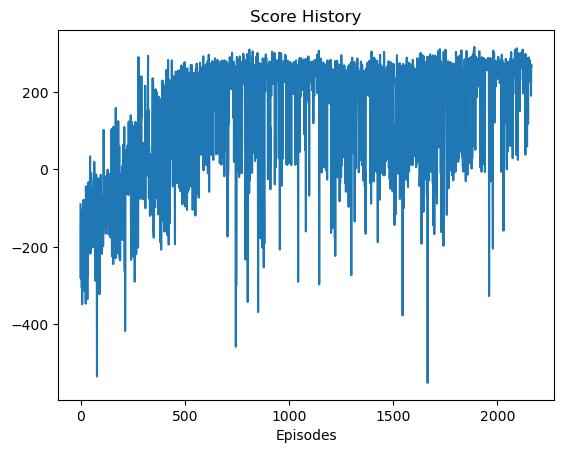

Loss,▂▇▃▁▅▁▁█▁▁▁▁▁▆▁▆▂▁▁▁▆▄▆▁▁▄▁▁▁▂▁▃▂▁▁▄▁▁▁▃
Score,▅▁▆▄▄▅▅▆▅▅▅▅▅▇▅▇▆▆▆▆▇▇█▆▆▇▅▆▅▆▆▇▄▆▆▇▆▆▆█
Loss,147.25836
Score,-67.36972


In [7]:
#Train the network
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset(seed=1111)
torch.manual_seed(1111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"])
plotScore(score_hist)

wandb.finish()

In [10]:
#Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="lunarLander_animation", loops=5)
env.close()

[303.1270519713443, 185.27601193738306, 220.3772097838139, 196.8101963197605, 244.12214383683866, 283.6875451370713, 268.62634303200934, 222.1153880367374, 245.25493617188582, 252.36768193651042]
-1.3976617110602803
271.3037895052824
247.3745502743999
225.89303231709044
228.5221008867172
Saving gif...Done!


 27%|##7       | 1350/5000 [  03:35<  09:42,  6.27ep/s, Score:  500.00, 100 score avg:  250.94]



Target Reached!


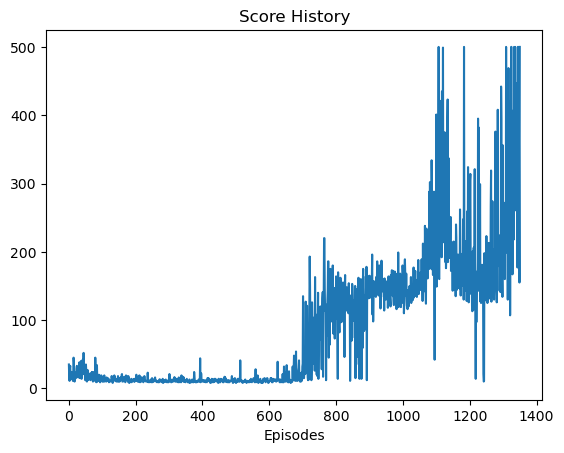

Loss,▁▁▁▁▁▁▂▂▂▁▃▃▄▂▄▂▂▄▃▃▁▁▁▂▁▁█▄▂▂▁▁▂▂▁▂▄▃▁▁
Score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,0.01343
Score,128.0


[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
500.0
500.0
500.0
500.0
500.0
Saving gif...Done!


In [11]:
#Cartpole
#Parameters TODO metterli con wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab3-Last",
    # We pass a run name (otherwise it'll be randomly assigned, like sunshine-lollypop-10)
    name=f"DQN-Cartpole",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "Cartpole",
    "dataset": "LunarLander",
    "episodes": 5000,
    "gamma": 0.99,
    "batch_size": 128,
    "target_score": 250,
    "C": 5,
    "tau": 1e-3,
    "memory_size": 10000,
    "episode_max_len": 500})

#Train the network
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset(seed=111)
torch.manual_seed(111)
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_obs = num_obs,
    n_actions = num_actions,
    batch_size = run.config["batch_size"],
    lr = run.config["learning_rate"],
    gamma = run.config["gamma"],
    mem_size = run.config["memory_size"],
    learn_step = run.config["C"],
    tau = run.config["tau"],
    )
score_hist = train(env, agent, n_episodes=run.config["episodes"], target=run.config["target_score"],
                  max_steps=run.config["episode_max_len"])
plotScore(score_hist)

wandb.finish()

#Test and save visual results as gif
test(env, agent, loops=10)

gym2gif(env, agent, filename="cartpole_animation", loops=5)
env.close()

OPPURE:







Altro metodo

In [2]:
#Excercise 3.2
import math
import random
import matplotlib
from collections import namedtuple, deque
from itertools import count

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#Replay Buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        #Save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    #usare temperatura peggiora i risultati

import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN_CNN(nn.Module):
    def __init__(self, num_actions):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) #32 filters of 8x8 with stride 4. ReLU Activation
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) #64 filters of 4x4 with stride 2. ReLU Activation
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) #64 filters of 3x3 stride 1. Followed by ReLU Activation
        self.fc1 = nn.Linear(3136, 512) 
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        return self.fc2(x)

In [3]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

env = gym.make("CartPole-v1")
device = "cpu"

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions, 20).to(device)
target_net = DQN(n_observations, n_actions, 20).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) #decidere se usare Adam o AdamW
memory = ReplayBuffer(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        #otherwise pick a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [4]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping -> ensures that gradient vector has norm at most equal to threshold
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss, reward_batch

Complete


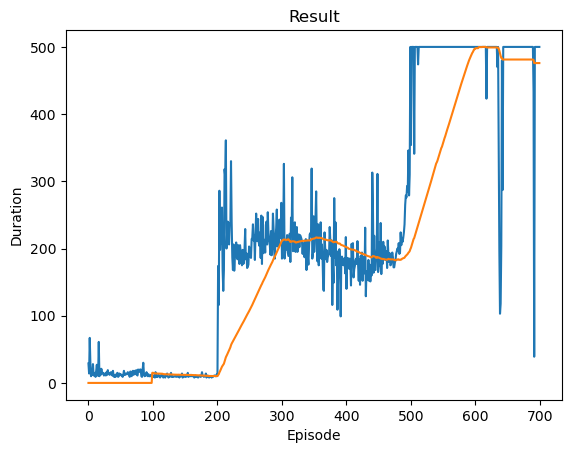

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
num_episodes = 700

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        #loss, running_reward = optimize_model()
        optimize_model()
        '''metrics = {"Policy Loss": loss,
                       "Running Reward": running_reward}
        wandb.log({**metrics}) '''

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
env.close()

For an agent to learn the system, it needs to explore different actions and states. For an agent to perform well, it would need to select what it believes to be the optimal action for a particular state.

The balance between the two is called the exploration-exploitation tradeoff.

One way to achieve this balance is by encouraging the agent to explore more towards the beginning of training and slowly transition to selecting the optimal actions once it has established reward values for most states.

We set a variable called epsilon to decide whether the agent can explore by taking a random action or if it should make a decision based on its q-value function.

-> per questo inizialmente fa male e poi migliora molto..

In [7]:
#Lunar Lander
env = gym.make("LunarLander-v2")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)


steps_done = 0
episode_durations = []

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Complete


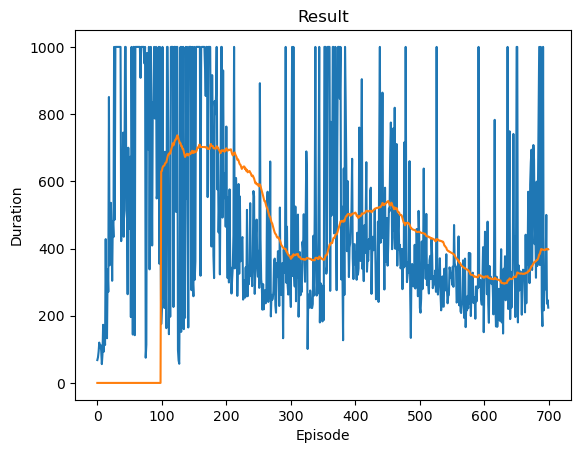

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
num_episodes = 700

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()